Text(0.5, 1.0, 'by hour')

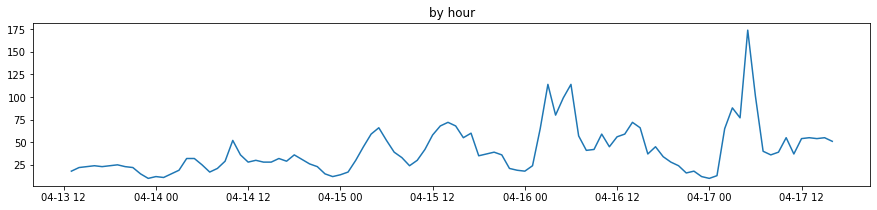

In [47]:
# load JSON
import json
import pandas as pd
 
# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
t_start = 55000
df_h = data[t_start:(t_start+100)]

# group by date
data_d = data.groupby(['just_date'],squeeze=True).mean()
data_d.columns = ['_'.join(col).strip() for col in data_d.columns.values]
data_d = data_d.reset_index()
data_d.columns = ['ds','y'] # rename column
df_d = data_d[0:2000]

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
#plt.figure(figsize=(15,3))
#plt.plot(df_d['ds'],df_d['y'])
#plt.title('by date')
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])
plt.title('by hour')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


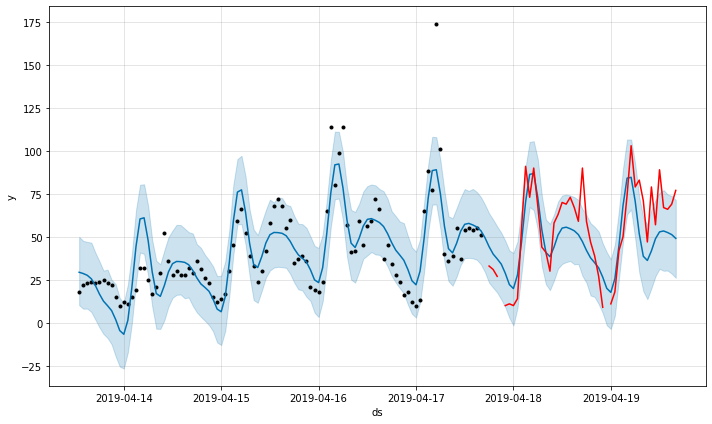

In [50]:
df = df_h # select daily or hourly daya

from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=0.5) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=48, freq='H')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
#components_fig = m.plot_components(forecast)
test = data[(t_start+101):(t_start+148)]
plt.plot(test['ds'],test['y'],color='r')

In [51]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='2 days', period='1 days', horizon ='1 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-04-15 16:00:00 and 2019-04-16 16:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-15 17:00:00,62.112416,52.809578,71.058842,60.0,2019-04-15 16:00:00
1,2019-04-15 18:00:00,63.001191,53.902584,72.189931,35.0,2019-04-15 16:00:00
2,2019-04-15 19:00:00,63.206905,54.069580,72.972934,37.0,2019-04-15 16:00:00
3,2019-04-15 20:00:00,62.490947,53.239431,72.077615,39.0,2019-04-15 16:00:00
4,2019-04-15 21:00:00,60.237279,51.062050,69.647233,36.0,2019-04-15 16:00:00


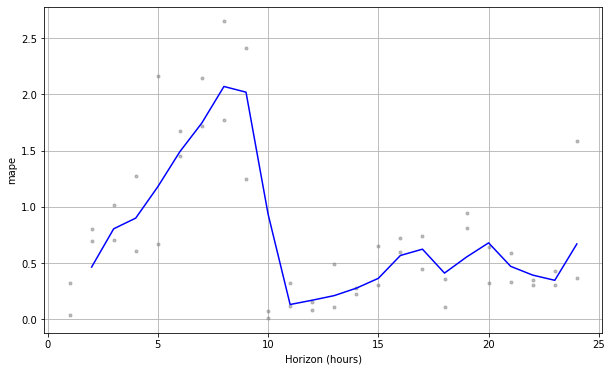

In [52]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [53]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 75.18139968648853%
SMAPE = 12.144302494863796%


In [ ]:
#import pickle
#pkl_path = "franklin-d-roosevelt/PM10_m.pkl"
#with open(pkl_path, "wb") as f:
#    # Pickle the 'Prophet' model using the highest protocol available.
#    pickle.dump(m, f)

## save the dataframe
#forecast.to_pickle("franklin-d-roosevelt/PM10_forecast.pkl")
#print("*** Data Saved ***")

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(forecast.ds,forecast.yhat,marker='.')
#plt.figure(figsize=(15,3))
plt.plot(data_d.ds[50001:52160],data_d.y[50001:52160])